In [7]:
import pandas as pd, json

def guess_emotion(t):
    t=t.lower()
    if any(k in t for k in ["hope","optimistic","together"]): return "hope"
    if any(k in t for k in ["happy","joy","excited"]): return "joy"
    if any(k in t for k in ["sad","tragic","grief"]): return "sadness"
    if any(k in t for k in ["angry","outrage","furious"]): return "anger"
    if any(k in t for k in ["fear","afraid","risk"]): return "fear"
    return "neutral"

def guess_frames(t):
    t=t.lower(); out=[]
    if "econom" in t: out.append("economic")
    if "health" in t: out.append("public_health")
    if any(w in t for w in ["climate","carbon","environment","planet"]): out.append("environmental")
    if any(w in t for w in ["research","evidence","experiment","data"]): out.append("scientific")
    if not out: out.append("none")
    return ", ".join(out[:3])

def guess_tech(t):
    t=t.lower(); out=[]
    if any(w in t for w in ["once upon","story","when i was"]): out.append("storytelling")
    if any(w in t for w in ["%"," percent"," million"," billion"," study"]): out.append("statistic")
    if any(w in t for w in ["professor","doctor","according to"]): out.append("authority")
    if "?" in t: out.append("rhetorical_question")
    if any(w in t for w in ["however","whereas","on the one hand"]): out.append("contrast")
    if any(w in t for w in ["repeat","again and again"]): out.append("repetition")
    if any(w in t for w in ["join us","take action","sign up","donate"]): out.append("call_to_action")
    return ", ".join(out[:5])

chunks = pd.read_csv("chunks.csv", usecols=["talk_id","chunk_id","title","speaker","chunk_text"])
rows=[]
for _, r in chunks.iterrows():
    txt = str(r["chunk_text"])
    rows.append({
        "talk_id": int(r["talk_id"]),
        "chunk_id": int(r["chunk_id"]),
        "title": r.get("title",""),
        "speaker": r.get("speaker",""),
        "primary_emotion": guess_emotion(txt),
        "frames": guess_frames(txt),
        "techniques": guess_tech(txt),
        "has_call_to_action": any(k in txt.lower() for k in ["join us","take action","sign up","donate"]),
        "key_claims_json": json.dumps([txt[:140]+"..."], ensure_ascii=False),
        "quality_notes": "heuristic"
    })
pd.DataFrame(rows).to_csv("features.csv", index=False, encoding="utf-8")


In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

FEATURES_CSV = "features.csv"     # output from  feature_extraction_API.ipynb
CHUNKS_CSV   = "chunks.csv"       # for n_chars / counts (optional, nice stats)

TALK_FEATS_CSV   = "talk_features.csv"
TALK_FEATS_JSONL = "talk_features.jsonl"
TOP_K = 5  #top frames/techniques per talk to keep

In [9]:
feats = pd.read_csv(FEATURES_CSV)
print("Chunk-feature rows:", len(feats))
feats.head(2)


Chunk-feature rows: 16128


,talk_id,chunk_id,title,speaker,primary_emotion,frames,techniques,has_call_to_action,key_claims_json,quality_notes
0,0,0,Averting the climate crisis,Al Gore,neutral,none,"storytelling, rhetorical_question",False,"[""Thank you so much, Chris. And it's truly a g...",heuristic
1,0,1,Averting the climate crisis,Al Gore,neutral,environmental,"storytelling, rhetorical_question",False,"[""\"" And I thought to myself, in the middle of...",heuristic


In [10]:
def flatten_split(series, sep=","):
    vals = []
    for v in series.fillna(""):
        parts = [p.strip() for p in str(v).split(sep)]
        vals.extend([p for p in parts if p])
    return vals

def top_k_counts(values, k=5):
    c = Counter(values)
    return [name for name, _ in c.most_common(k)]

def dedupe_strings(strings, min_len=15):
    seen, out = set(), []
    for s in strings:
        s = str(s).strip()
        if len(s) < min_len: 
            continue
        key = " ".join(s.lower().split())
        if key in seen: 
            continue
        seen.add(key); out.append(s)
    return out

def to_jsonl(rows, path):
    with open(path, "w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")


In [11]:
# making sure chunk order is correct 
feats["chunk_id"] = feats["chunk_id"].astype(int)
feats = feats.sort_values(["talk_id", "chunk_id"])

talk_rows = []
jsonl_rows = []

for talk_id, g in feats.groupby("talk_id"):
    title   = g["title"].iloc[0] if "title" in g.columns else ""
    speaker = g["speaker"].iloc[0] if "speaker" in g.columns else ""

    # 1) Emotion trajectory + summaries
    emo_traj = g["primary_emotion"].fillna("neutral").tolist()
    final_emotion = emo_traj[-1] if emo_traj else "neutral"
    dominant_emotion = Counter(emo_traj).most_common(1)[0][0] if emo_traj else "neutral"

    # 2) Frames / Techniques (top-k lists)
    frames_all = flatten_split(g["frames"]) if "frames" in g.columns else []
    tech_all   = flatten_split(g["techniques"]) if "techniques" in g.columns else []
    top_frames = top_k_counts(frames_all, k=TOP_K)
    top_tech   = top_k_counts(tech_all,   k=TOP_K)

    # 3) Call-to-action rate
    cta_rate = float(g.get("has_call_to_action", pd.Series([False]*len(g))).mean())

    # 4) Key claims (combine + dedupe)
    claims = []
    if "key_claims_json" in g.columns:
        for v in g["key_claims_json"].fillna("[]"):
            try:
                arr = json.loads(v)
                if isinstance(arr, list): claims.extend(arr)
            except Exception:
                pass
    claims = dedupe_strings(claims, min_len=15)[:10]

    talk_rows.append({
        "talk_id": talk_id,
        "title": title,
        "speaker": speaker,
        "n_chunks": len(g),
        "final_emotion": final_emotion,
        "dominant_emotion": dominant_emotion,
        "top_frames": ", ".join(top_frames),
        "top_techniques": ", ".join(top_tech),
        "cta_rate": round(cta_rate, 3),
        "n_claims": len(claims)
    })

    jsonl_rows.append({
        "talk_id": int(talk_id),
        "title": title,
        "speaker": speaker,
        "emotion_trajectory": emo_traj,
        "final_emotion": final_emotion,
        "dominant_emotion": dominant_emotion,
        "top_frames": top_frames,
        "top_techniques": top_tech,
        "cta_rate": cta_rate,
        "key_claims": claims
    })

talk_df = pd.DataFrame(talk_rows).sort_values("talk_id")
print("Talks:", len(talk_df))
talk_df.head(3)


Talks: 3956


,talk_id,title,speaker,n_chunks,final_emotion,dominant_emotion,top_frames,top_techniques,cta_rate,n_claims
0,0,Averting the climate crisis,Al Gore,5,neutral,neutral,"environmental, none","rhetorical_question, storytelling, repetition",0.0,5
1,1,The best stats you've ever seen,Hans Rosling,7,neutral,neutral,"scientific, public_health, economic, environme...","rhetorical_question, statistic, storytelling, ...",0.0,7
2,2,Simplicity sells,David Pogue,7,neutral,neutral,"none, scientific, environmental","rhetorical_question, statistic, storytelling",0.0,7


In [12]:
try:
    chunks = pd.read_csv(CHUNKS_CSV, usecols=["talk_id","n_chars"])
    talk_sizes = chunks.groupby("talk_id")["n_chars"].agg(["count","mean","sum"]).reset_index()
    talk_sizes.columns = ["talk_id","chunks_per_talk","avg_chars_per_chunk","total_chars"]
    talk_df = talk_df.merge(talk_sizes, on="talk_id", how="left")
except Exception as e:
    print("Skipping size stats (no chunks.csv?) ->", e)

talk_df.head(2)


,talk_id,title,speaker,n_chunks,final_emotion,dominant_emotion,top_frames,top_techniques,cta_rate,n_claims,chunks_per_talk,avg_chars_per_chunk,total_chars
0,0,Averting the climate crisis,Al Gore,5,neutral,neutral,"environmental, none","rhetorical_question, storytelling, repetition",0.0,5,5,2507.000000,12535
1,1,The best stats you've ever seen,Hans Rosling,7,neutral,neutral,"scientific, public_health, economic, environme...","rhetorical_question, statistic, storytelling, ...",0.0,7,7,2570.857143,17996


In [13]:
try:
    chunks = pd.read_csv(CHUNKS_CSV, usecols=["talk_id","n_chars"])
    talk_sizes = chunks.groupby("talk_id")["n_chars"].agg(["count","mean","sum"]).reset_index()
    talk_sizes.columns = ["talk_id","chunks_per_talk","avg_chars_per_chunk","total_chars"]
    talk_df = talk_df.merge(talk_sizes, on="talk_id", how="left")
except Exception as e:
    print("Skipping size stats (no chunks.csv?) ->", e)

talk_df.head(2)


,talk_id,title,speaker,n_chunks,final_emotion,dominant_emotion,top_frames,top_techniques,cta_rate,n_claims,chunks_per_talk_x,avg_chars_per_chunk_x,total_chars_x,chunks_per_talk_y,avg_chars_per_chunk_y,total_chars_y
0,0,Averting the climate crisis,Al Gore,5,neutral,neutral,"environmental, none","rhetorical_question, storytelling, repetition",0.0,5,5,2507.000000,12535,5,2507.000000,12535
1,1,The best stats you've ever seen,Hans Rosling,7,neutral,neutral,"scientific, public_health, economic, environme...","rhetorical_question, statistic, storytelling, ...",0.0,7,7,2570.857143,17996,7,2570.857143,17996


In [15]:
talk_df.to_csv(TALK_FEATS_CSV, index=False, encoding="utf-8")
to_jsonl(jsonl_rows, TALK_FEATS_JSONL)


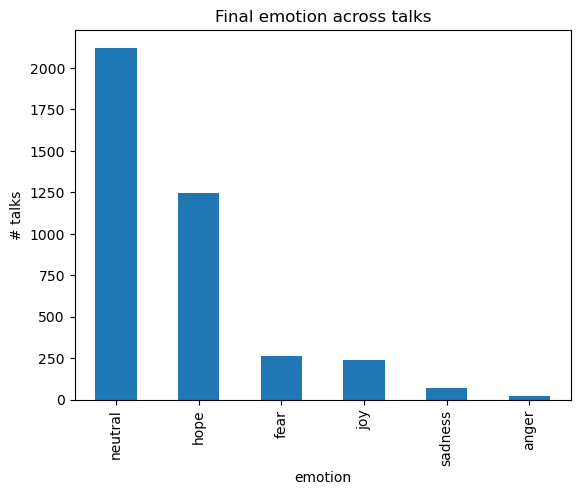

In [16]:
plt.figure()
talk_df["final_emotion"].value_counts().plot(kind="bar")
plt.title("Final emotion across talks")
plt.xlabel("emotion"); plt.ylabel("# talks"); plt.show()


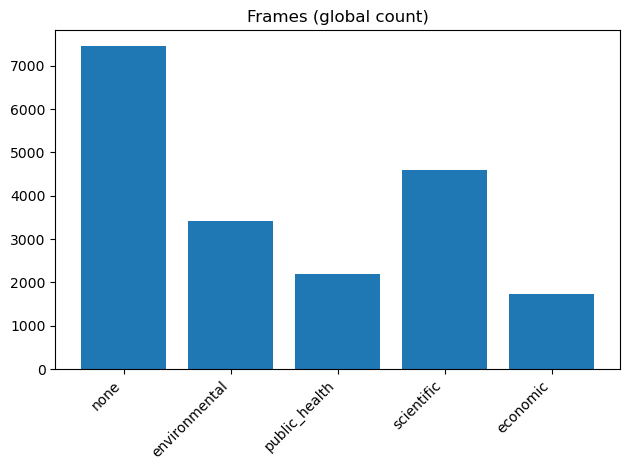

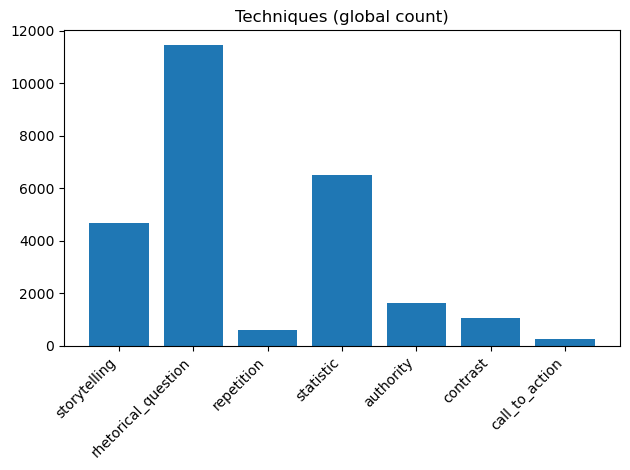

In [17]:
frames_all = flatten_split(feats["frames"]) if "frames" in feats.columns else []
tech_all   = flatten_split(feats["techniques"]) if "techniques" in feats.columns else []

if frames_all:
    fc = Counter(frames_all)
    plt.figure()
    plt.bar(fc.keys(), fc.values())
    plt.title("Frames (global count)"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

if tech_all:
    tc = Counter(tech_all)
    plt.figure()
    plt.bar(tc.keys(), tc.values())
    plt.title("Techniques (global count)"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


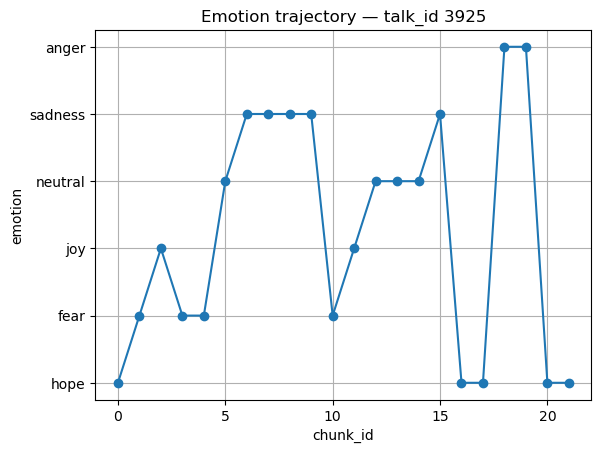

In [18]:
# pick the talk with the most chunks
counts = feats.groupby("talk_id")["chunk_id"].count().sort_values(ascending=False)
example_id = counts.index[0]
one = feats[feats["talk_id"]==example_id].sort_values("chunk_id")

emos = one["primary_emotion"].fillna("neutral").tolist()
uniq = list(dict.fromkeys(emos))
emap = {e:i for i,e in enumerate(uniq)}
y = [emap[e] for e in emos]

plt.figure()
plt.plot(one["chunk_id"], y, marker="o")
plt.yticks(list(emap.values()), list(emap.keys()))
plt.title(f"Emotion trajectory — talk_id {int(example_id)}")
plt.xlabel("chunk_id"); plt.ylabel("emotion"); plt.grid(True); plt.show()
